# Graviational Waves in Python
This notebook intends to showcase the basic functionality of various libraries for analysing gravitational waves in python

## PyCBC
PyCBC can be used to load, analyse and plot GW data. To start out we can print the catalog of events.

In [8]:
from pycbc import catalog

for merger_name in catalog.Catalog(source='gwtc-4.0'):
    print(merger_name)

GW240109_050431-v1
GW240107_013215-v1
GW240105_151143-v1
GW240104_164932-v1
GW231231_154016-v1
GW231231_120147-v1
GW231230_170116-v1
GW231226_101520-v1
GW231224_024321-v1
GW231223_202619-v1
GW231223_075055-v1
GW231223_032836-v1
GW231221_135041-v1
GW231220_173406-v1
GW231213_111417-v1
GW231206_233901-v1
GW231206_233134-v1
GW231206_010629-v1
GW231204_090648-v1
GW231129_081745-v1
GW231127_165300-v1
GW231126_010928-v1
GW231123_135430-v2
GW231120_022103-v1
GW231119_075248-v1
GW231118_090602-v1
GW231118_071402-v1
GW231118_005626-v1
GW231114_043211-v1
GW231113_200417-v1
GW231113_150041-v1
GW231113_122623-v1
GW231110_040320-v1
GW231108_125142-v1
GW231104_133418-v1
GW231102_232433-v1
GW231102_071736-v1
GW231102_052214-v1
GW231029_111508-v1
GW231028_153006-v1
GW231026_130704-v1
GW231020_142947-v1
GW231018_233037-v1
GW231014_040532-v1
GW231013_135504-v1
GW231008_142521-v1
GW231005_144455-v1
GW231005_091549-v1
GW231005_021030-v1
GW231004_232346-v1
GW231002_143916-v1
GW231001_140220-v1
GW230930_110

We can now pick one to load: "GW191204_110529-v1"

dict_keys(['commonName', 'version', 'catalog.shortName', 'GPS', 'reference', 'jsonurl', 'strain', 'mass_1_source', 'mass_1_source_lower', 'mass_1_source_upper', 'mass_1_source_unit', 'mass_2_source', 'mass_2_source_lower', 'mass_2_source_upper', 'mass_2_source_unit', 'network_matched_filter_snr', 'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper', 'network_matched_filter_snr_unit', 'luminosity_distance', 'luminosity_distance_lower', 'luminosity_distance_upper', 'luminosity_distance_unit', 'chi_eff', 'chi_eff_lower', 'chi_eff_upper', 'chi_eff_unit', 'total_mass_source', 'total_mass_source_lower', 'total_mass_source_upper', 'total_mass_source_unit', 'chirp_mass_source', 'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass_source_unit', 'chirp_mass', 'chirp_mass_lower', 'chirp_mass_upper', 'chirp_mass_unit', 'redshift', 'redshift_lower', 'redshift_upper', 'redshift_unit', 'far', 'far_lower', 'far_upper', 'far_unit', 'p_astro', 'p_astro_lower', 'p_astro_upp

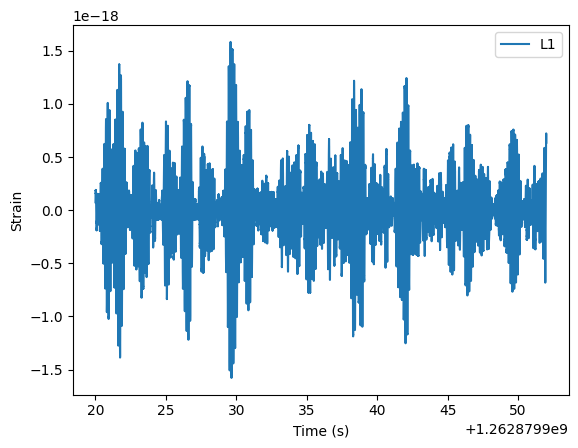

Text(0.5, 0, 'Time (s)')

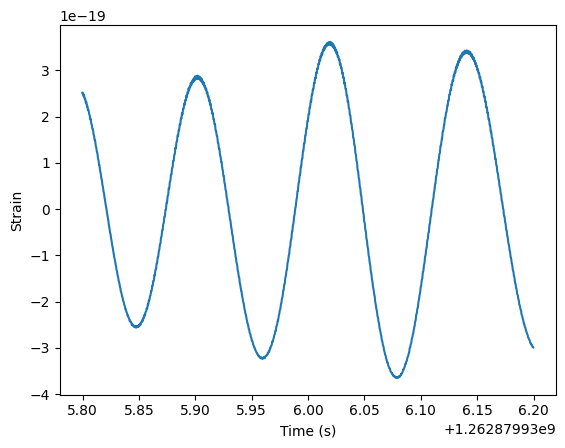

In [73]:
import matplotlib.pyplot as plt
m = catalog.Merger("GW200112_155838-v1", source='gwtc-3')

print(m.data.keys())

# the raw data from the interferometers is stored in strain
# ts_han = m.strain('H1') # for different detectors
ts_liv = m.strain('L1')

# plt.plot(ts_han.sample_times, ts_han, label="H1")
plt.plot(ts_liv.sample_times, ts_liv, label="L1")
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

merge_window = ts_liv.time_slice(m.time - 0.2, m.time + 0.2 )
plt.plot(merge_window.sample_times, merge_window)
plt.ylabel('Strain')
plt.xlabel('Time (s)')

# Standard Preprocessing
PyCBC also has support for doing some standard denoising of the data. We focus on the L1 interferometer strain.

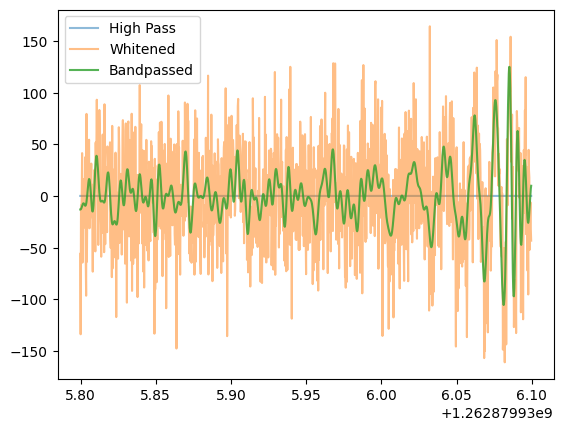

In [74]:
high_pass = ts_liv.highpass_fir(15, 512) # suppress low frequency noise

whitened = high_pass.whiten(4, 4) # Flatten Freq Response of PSD
bpsd = whitened.highpass_fir(30, 512).lowpass_fir(250, 512) # two more freq filters

# zoom in on event
event = bpsd.time_slice(m.time -0.2, m.time + 0.1)

plt.plot(event.sample_times, high_pass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, whitened.time_slice(m.time -0.2, m.time + 0.1), label="Whitened", alpha=0.5)
plt.plot(event.sample_times, event, label="Bandpassed", alpha=0.8)
plt.legend()
plt.show()


# Visualization
Graviational waves are commonly visualized using a constant Q transform spectrogram.

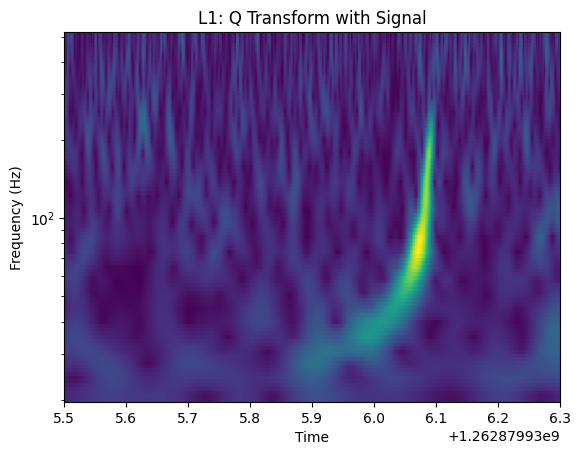

In [75]:
window = whitened.time_slice(m.time - 5, m.time + 5)
times, freqs, power = window.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20,512))

plt.pcolormesh(times, freqs, power**0.5)
plt.xlim(m.time -0.5, m.time + 0.3)
plt.title("L1: Q Transform with Signal")
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()


## Generating BBH signals
(stolen from doc :))

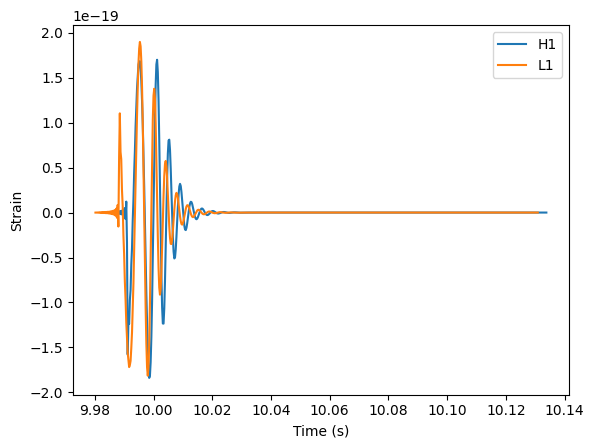

2.1 18.099755859375


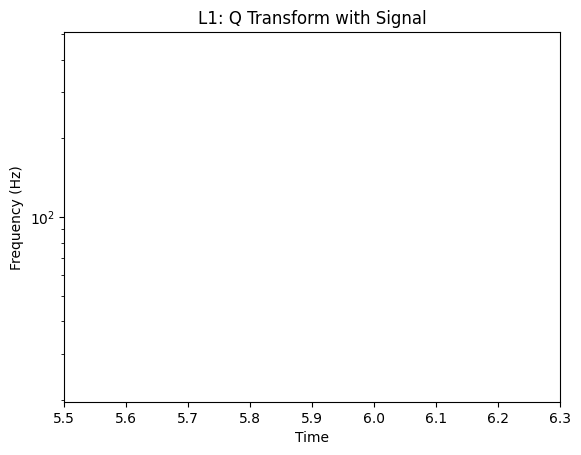

In [ ]:
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.types import TimeSeries
import numpy as np

m = catalog.Merger("GW150914")


apx = 'SEOBNRv4'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=m.mass1,
                         mass2=m.mass2,
                         inclination=1.23,
                         coa_phase=2.45,
                         delta_t=1.0/4096,
                         f_lower=100)

det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
end_time = 10
declination = 0.5333
right_ascension = 2
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)

plt.plot(signal_h1.sample_times, signal_h1, label='H1')
plt.plot(signal_l1.sample_times, signal_l1, label='L1')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

0.0 19.999755859375


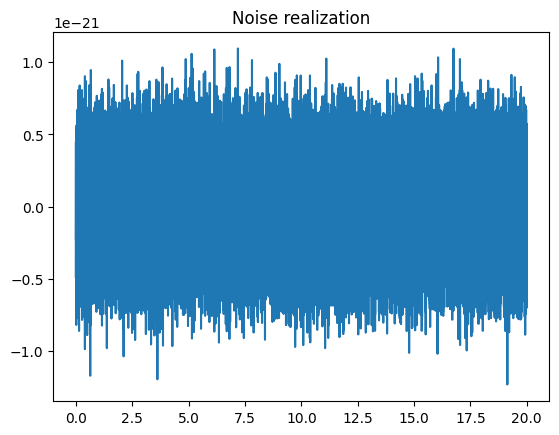

In [53]:
from torch import Tensor
from pycbc.noise import noise_from_psd
from pycbc.psd.analytical import aLIGOZeroDetHighPower
sample_duration = 20
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

delta_t = 1.0 / 4096
tsamples = int(sample_duration / delta_t)
ts = noise_from_psd(tsamples, delta_t, psd) # one long string of noise
print(ts.sample_times[0], ts.sample_times[-1])

plt.title("Noise realization")
plt.plot(ts.sample_times, ts)
plt.show()

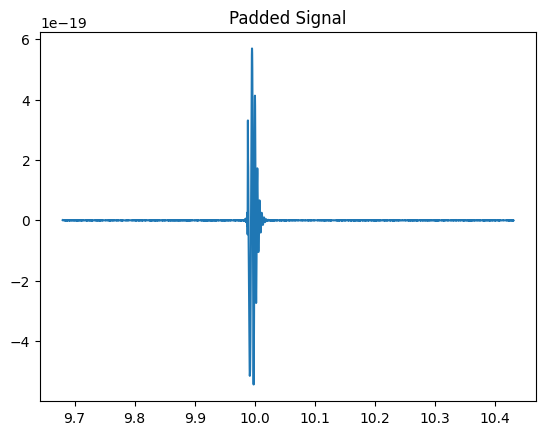

In [48]:
ts = ts.inject(signal_l1)
window = ts.time_slice(signal_l1.start_time - 0.3, signal_l1.end_time + 0.3)
plt.title("Padded Signal")
plt.plot(window.sample_times, window)
plt.show()